In [1]:
# Idea:
  # Use a single model for both the risk classification and the bad actor identification using a double CNN

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from scipy import ndimage
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime

import time

In [4]:
root_path = '/hpf/largeprojects/fkhalvati/Jay/new/ai_hub'

In [5]:
# Preprocessing data
raw_data = pd.read_excel(os.path.join(root_path, 'data/risk_sheet.xlsx'))

/localhd/1374374/ipykernel_4100/276505020.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  raw_data = pd.read_excel(os.path.join(root_path, 'data/risk_sheet.xlsx'))


In [6]:
# Dropping likely irrelevant columns (additional reasoning: dates are annoying to parse into features, and GENDER had too many nulls that weren't easily resolvable)
data = raw_data.drop(['GENDER', 'CUSTOMER_ID', 'NAME', 'CUST_ADD_DT', 'OCPTN_NM'], axis=1)

In [7]:
non_ordinal_data_columns = ['RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL'] # to one hot encode
ordinal_data_columns = ['BIRTH_DT', 'OCPTN_RISK', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY'] # to label encode
normalize_data_columns = ['QUERY_RISK', 'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_IN', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT'] # to normalize (min-max)

In [8]:
data['BIRTH_DT'] = data['BIRTH_DT'].dt.strftime('%Y').astype(float)

In [9]:
# Min-max scaling certain features
minmax_scaler = MinMaxScaler()
data[normalize_data_columns] = minmax_scaler.fit_transform(data[normalize_data_columns])

In [10]:
# 1 indexing the ordinal columns when label encoding so that null values can be set to 0 to indicate that it is "irrelevant information" rather than having to remove these data samples
for col in ordinal_data_columns:
  if col == 'BIRTH_DT':
    continue
  data[col] = data[col].str.lower()
  data[col] = data[col].replace('low', 1)
  data[col] = data[col].replace('moderate', 2)
  data[col] = data[col].replace('high', 3)
  data[col].fillna(0, inplace = True)

# RISK is the target variable and not only has slightly different names (moderate -> medium), but it also doesn't have any nulls, so can 0 index without concern
data['RISK'] = data['RISK'].str.lower()
data['RISK'] = data['RISK'].replace('low', 0)
data['RISK'] = data['RISK'].replace('medium', 1)
data['RISK'] = data['RISK'].replace('high', 2)

In [11]:
def balance_dset(df, target):
    high_risk_data = df[df[target]==2].copy()
    labels = df[target].copy()
    all_mid_risk = labels[labels == 1]
    all_low_risk = labels[labels == 0]
    mid_risk_to_keep = np.random.choice(all_mid_risk.index, size=high_risk_data.shape[0], replace=False)
    low_risk_to_keep = np.random.choice(all_low_risk.index, size=high_risk_data.shape[0], replace=False)
    mid_risk_data = df.iloc[mid_risk_to_keep].copy()
    low_risk_data = df.iloc[low_risk_to_keep].copy()
    new_df = pd.concat([high_risk_data, mid_risk_data, low_risk_data], axis=0)
    return new_df

data = balance_dset(data, "RISK")

In [12]:
data_col_names = list(data.columns.values)
data_col_names.remove('RISK')
labels = torch.from_numpy(data['RISK'].to_numpy()) # labels first because data is overridden in the next line
data = torch.from_numpy(data[data_col_names].to_numpy())

In [13]:
# Prepare idxs, save if new, else load for consistency

if not (os.path.exists(os.path.join(root_path, 'data/train_idxs.npy')) or os.path.exists(os.path.join(root_path, 'data/val_idxs.npy')) or os.path.exists(os.path.join(root_path, 'data/test_idxs.npy'))):
  train_idxs, val_test_idxs = train_test_split(list(range(data.shape[0])), test_size=0.2)
  val_idxs, test_idxs = train_test_split(val_test_idxs, test_size=0.5)
  train_idxs = np.array(train_idxs)
  val_idxs = np.array(val_idxs)
  test_idxs = np.array(test_idxs)

if not (os.path.exists(os.path.join(root_path, 'data/train_idxs.npy')) or os.path.exists(os.path.join(root_path, 'data/val_idxs.npy')) or os.path.exists(os.path.join(root_path, 'data/test_idxs.npy'))):
  np.save(os.path.join(root_path, 'data/train_idxs.npy'), train_idxs)
  np.save(os.path.join(root_path, 'data/val_idxs.npy'), val_idxs)
  np.save(os.path.join(root_path, 'data/test_idxs.npy'), test_idxs)
else:
  train_idxs = np.load(os.path.join(root_path, 'data/train_idxs.npy'))
  val_idxs = np.load(os.path.join(root_path, 'data/val_idxs.npy'))
  test_idxs = np.load(os.path.join(root_path, 'data/test_idxs.npy'))

In [14]:
# Preparing data
data = data.squeeze().unsqueeze(1).float()
train_data = data[train_idxs]
val_data = data[val_idxs]
train_labels = labels[train_idxs]
val_labels = labels[val_idxs]

In [15]:
# Hyperparameters

# checkpoint_path = os.path.join(root_path, "checkpoints/task2_checkpoint.pt")
checkpoint_path = "task2_checkpoint.pt"

initial_learning_rate = 0.00002

num_epochs = 100
batch_size = 32
epochs_per_summary = 1

num_input_features = data.shape[1]
num_initial_features = 200

use_cuda = True

In [16]:
# Model Definition

class EncoderModel(nn.Module):
    def __init__(self, num_input_features, num_features):
        super(EncoderModel, self).__init__()
        # Blocks
        #####################
        in_0 = num_input_features
        out_0 = num_initial_features
        self.block_0 = nn.Sequential(
            nn.Conv1d(in_0, out_0, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_0),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
        )

        in_1 = out_0
        out_1 = math.floor(in_1 * 1.25)
        self.block_1 = nn.Sequential(
            nn.Conv1d(in_1, out_1, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
        )

        in_2 = out_1
        out_2 = math.floor(in_2 * 1.25)
        self.block_2 = nn.Sequential(
            nn.Conv1d(in_2, out_2, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
        )

        in_3 = out_2
        out_3 = math.floor(in_3 * 1.25)
        self.block_3 = nn.Sequential(
            nn.Conv1d(in_3, out_3, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
        )

        self.out_channels = [out_3, out_2, out_1, out_0] # To be used for decoders
        #####################

    def forward(self, x):
        in_0 = x
        out_0 = self.block_0(in_0)

        in_1 = out_0
        out_1 = self.block_1(in_1)

        in_2 = out_1
        out_2 = self.block_2(in_2)

        in_3 = out_2
        out_3 = self.block_3(in_3)
        
        return out_3, out_2, out_1, out_0

In [17]:
# Model Definition

class DecoderModel(nn.Module):
    def __init__(self, encoder_out_channels):
        super(DecoderModel, self).__init__()
        # Blocks
        #####################
        num_features = encoder_out_channels[0]
        encoder_out_channels = encoder_out_channels[1:]

        in_0 = num_features
        out_0 = encoder_out_channels[0]
        self.block_0 = nn.Sequential(
            nn.ConvTranspose1d(in_0, out_0, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_0),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        in_1 = encoder_out_channels[0]
        out_1 = encoder_out_channels[1]
        self.block_1 = nn.Sequential(
            nn.ConvTranspose1d(in_1, out_1, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_1),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        in_2 = encoder_out_channels[1]
        out_2 = encoder_out_channels[2]
        self.block_2 = nn.Sequential(
            nn.ConvTranspose1d(in_2, out_2, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_2),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        in_3 = encoder_out_channels[2]
        out_3 = int(in_3 // 1.25)
        self.block_3 = nn.Sequential(
            nn.ConvTranspose1d(in_3, out_3, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(out_3),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        # Skip connections
        #####################
        self.preskip_1 = nn.Sequential(
            nn.Conv1d(in_channels=encoder_out_channels[0], out_channels=encoder_out_channels[0], kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip_1 = nn.Sequential(
            nn.Conv1d(in_channels=in_1 * 2, out_channels=in_1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        self.preskip_2 = nn.Sequential(
            nn.Conv1d(in_channels=encoder_out_channels[1], out_channels=encoder_out_channels[1], kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip_2 = nn.Sequential(
            nn.Conv1d(in_channels=in_2 * 2, out_channels=in_2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )

        self.preskip_3 = nn.Sequential(
            nn.Conv1d(in_channels=encoder_out_channels[2], out_channels=encoder_out_channels[2], kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        self.skip_3 = nn.Sequential(
            nn.Conv1d(in_channels=in_3 * 2, out_channels=in_3, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(True),
        )
        #####################

    def forward(self, encoder_out_3, encoder_out_2, encoder_out_1, encoder_out_0):
        in_0 = encoder_out_3
        out_0 = self.block_0(encoder_out_3)

        in_1 = self.skip_1(torch.cat((out_0, self.preskip_1(encoder_out_2)), 1))
        out_1 = self.block_1(in_1)

        in_2 = self.skip_2(torch.cat((out_1, self.preskip_2(encoder_out_1)), 1))
        out_2 = self.block_2(in_2)

        in_3 = self.skip_3(torch.cat((out_2, self.preskip_3(encoder_out_0)), 1))
        out_3 = self.block_3(in_3)
        
        return out_3

In [18]:
# Model Definition

class CombinedModel(nn.Module):
    def __init__(self, num_input_features, num_initial_features):
        super(CombinedModel, self).__init__()

        self.encoder = EncoderModel(num_input_features, num_initial_features)
        self.decoder_risk = DecoderModel(self.encoder.out_channels)
        self.decoder_badactor = DecoderModel(self.encoder.out_channels)

        flattened_size = 2560 # Just checked manually

        self.linear_risk = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size,1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 3),
            # nn.Softmax(dim=1)
        )

        self.linear_badactor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size,1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 2),
            # nn.Softmax(dim=1)
        )
        
        #####################

    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_risk_out = self.decoder_risk(*encoder_out)
        #decoder_badactor_out = self.decoder_badactor(*encoder_out)
        risk_scores = self.linear_risk(decoder_risk_out)
        #badactor_scores = self.linear_badactor(decoder_badactor_out)
        
        return risk_scores#, badactor_scores

In [19]:
model = CombinedModel(num_input_features, num_initial_features)

In [55]:
# weights = 1 / torch.unique(train_labels, return_counts=True)[1]
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)

In [20]:
class classification_dataset(Dataset):
    def __init__(self, data, labels):
    # def __init__(self, data, tumor_labels):
        super().__init__()
        # data is (N, 4, H, W)
        # labels is (N, H, W)

        self.num_data = len(data)
        self.data = data.float()
        self.labels = labels.long()

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        return self.data[idx] , self.labels[idx]


train_dataset = classification_dataset(train_data, train_labels)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=True, shuffle=False, sampler=sampler)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=True, shuffle=False)
val_dataset = classification_dataset(val_data, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=False, shuffle=False)

In [59]:
cross_entropy_loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(lr=initial_learning_rate, params=model.parameters(), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs // 4, gamma=0.5)

initial_epoch = 1
if os.path.exists(checkpoint_path):
    # assert os.path.exists(checkpoint_path), "Checkpoint must exist"

    checkpoint = torch.load(checkpoint_path)
    initial_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

if use_cuda:
    model = nn.DataParallel(model)
    model = model.cuda()
    # torch.backends.cudnn.enabled = False

start_time = time.time()
epoch_start_time = time.time()
tic = time.time()

train_losses = []
val_losses = []

print("Beginning training")
for epoch in range(initial_epoch, num_epochs + 1):

    total_train_loss = 0
    total_train_batches = 0

    for batch, (data, labels) in enumerate(train_dataloader):
        if use_cuda:
            data = data.cuda()
            labels = labels.cuda()
        
        outs = model(data)
        
        loss = cross_entropy_loss(outs, labels)

        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        total_train_loss += float(loss)
        total_train_batches += 1
        
        if time.time() - tic > 10 * 60: # 10 minutes
            checkpoint_state = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
            }
            torch.save(checkpoint_state, checkpoint_path)
            print("Checkpoint saved")
            
            tic = time.time()

    total_train_loss /= total_train_batches
    train_losses.append(total_train_loss)

    with torch.no_grad():
        model.eval()

        total_val_loss = 0
        total_val_batches = 0
        
        for batch, (data, labels) in enumerate(val_dataloader):
            if use_cuda:
                data = data.cuda()
                labels = labels.cuda()
        
            outs = model(data)
            
            loss = cross_entropy_loss(outs, labels)

            total_val_loss += float(loss)
            total_val_batches += 1

        total_val_loss /= total_val_batches
        val_losses.append(total_val_loss)

        model.train()

    scheduler.step()

    if epoch % epochs_per_summary == epochs_per_summary - 1:
        epoch_time = (time.time() - epoch_start_time) / epochs_per_summary

        progress_msg = "Epoch: {epoch}, Train Total Loss {total_loss}".format(epoch=epoch, total_loss=total_train_loss)
        progress_msg += ", Val Total Loss {total_loss}, Time {time}".format(total_loss=total_val_loss, time=epoch_time)
        
        print(progress_msg)

        checkpoint_state = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
        }
        
        torch.save(checkpoint_state, checkpoint_path)
        print("Checkpoint saved")
        
        tic = time.time()
        epoch_start_time = time.time()

end_time = time.time()
print("Completed training.")


# In[ ]:


torch.save(model.state_dict(), os.path.join(root_path, "task2_model.pt"))


Beginning training
Epoch: 1, Train Total Loss 0.5928252770662308, Val Total Loss 0.3029481882034843, Time 61.60494017601013
Checkpoint saved
Epoch: 2, Train Total Loss 0.35678710005283354, Val Total Loss 0.3107141870965581, Time 61.845152139663696
Checkpoint saved
Epoch: 3, Train Total Loss 0.33693918956716856, Val Total Loss 0.289167673015264, Time 63.11667847633362
Checkpoint saved
Epoch: 4, Train Total Loss 0.3234548786441485, Val Total Loss 0.29065021990077583, Time 62.30676531791687
Checkpoint saved
Epoch: 5, Train Total Loss 0.315808067603906, Val Total Loss 0.27059253157456037, Time 61.6445746421814
Checkpoint saved
Epoch: 6, Train Total Loss 0.31486901716391247, Val Total Loss 0.28152657162024775, Time 61.57389259338379
Checkpoint saved
Epoch: 7, Train Total Loss 0.31704875924189885, Val Total Loss 0.27078492270667415, Time 62.17567706108093
Checkpoint saved
Epoch: 8, Train Total Loss 0.3160504162788391, Val Total Loss 0.2694760309035844, Time 61.98514771461487
Checkpoint saved

Epoch: 67, Train Total Loss 0.3254732467095057, Val Total Loss 0.29147288597214704, Time 61.63095736503601
Checkpoint saved
Epoch: 68, Train Total Loss 0.3255625820239385, Val Total Loss 0.29514287604388395, Time 61.853041887283325
Checkpoint saved
Epoch: 69, Train Total Loss 0.3256212360103925, Val Total Loss 0.29145819191803046, Time 61.69941425323486
Checkpoint saved
Epoch: 70, Train Total Loss 0.32583613635698955, Val Total Loss 0.29623283892234503, Time 61.537519216537476
Checkpoint saved
Epoch: 71, Train Total Loss 0.3249875966668129, Val Total Loss 0.2946998504147347, Time 61.55144143104553
Checkpoint saved
Epoch: 72, Train Total Loss 0.3248446500102679, Val Total Loss 0.296325755541894, Time 61.01585674285889
Checkpoint saved
Epoch: 73, Train Total Loss 0.3258172984560331, Val Total Loss 0.29480375687895555, Time 62.08413910865784
Checkpoint saved
Epoch: 74, Train Total Loss 0.3248152036070824, Val Total Loss 0.29585618759269144, Time 60.589781522750854
Checkpoint saved
Epoch: 

In [60]:
np.save(os.path.join(root_path, 'task2_train_losses.npy'), np.array(train_losses))
np.save(os.path.join(root_path, 'task2_val_losses.npy'), np.array(val_losses))

# Getting stats (note that training code block was not run prior to this point)

In [24]:
model = nn.DataParallel(model)

In [25]:
model.load_state_dict(torch.load(os.path.join(root_path, "task2_model.pt")))

<All keys matched successfully>

In [26]:
test_data = data[test_idxs]
test_labels = labels[test_idxs]

In [27]:
test_data.shape

torch.Size([15000, 1, 16])

In [28]:
test_dataset = classification_dataset(test_data, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=False, shuffle=False)

In [46]:
softmax = nn.Softmax(dim=1)
all_predictions = []
all_probabilities = []
all_gts = []
with torch.no_grad():
        model.eval()

        total_test_loss = 0
        total_test_batches = 0
        
        for batch, (data, labels) in enumerate(test_dataloader):
            if use_cuda:
                data = data.cuda()
                labels = labels.cuda()
        
            outs = model(data)
            preds = softmax(outs).detach().cpu()
            all_predictions.append(torch.argmax(preds, dim=1))
            all_probabilities.append(torch.max(preds, dim=1)[0])
            all_gts.append(labels.detach().cpu())

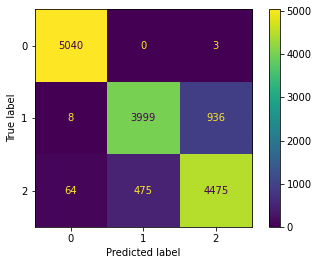

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(torch.cat(all_gts).numpy(), torch.cat(all_predictions).numpy(), labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot()
plt.show()

In [40]:
np.equal(torch.cat(all_gts).numpy(), torch.cat(all_predictions).numpy()).sum() / len(torch.cat(all_gts))

0.9009333333333334

In [54]:
consolidated_test_results = torch.cat((torch.cat(all_probabilities).unsqueeze(1), torch.cat(all_predictions).unsqueeze(1), torch.cat(all_gts).unsqueeze(1)), dim=1).numpy()

In [57]:
test_results = pd.DataFrame(consolidated_test_results, columns=['Probabilities', 'Predictions', 'Ground Truth'])

In [61]:
test_results.to_csv(os.path.join(root_path, "test_results.csv"), index=False)

In [62]:
val_dataset = classification_dataset(val_data, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=False, shuffle=False)

In [63]:
softmax = nn.Softmax(dim=1)
all_predictions = []
all_probabilities = []
all_gts = []
with torch.no_grad():
        model.eval()

        total_val_loss = 0
        total_val_batches = 0
        
        for batch, (data, labels) in enumerate(val_dataloader):
            if use_cuda:
                data = data.cuda()
                labels = labels.cuda()
        
            outs = model(data)
            preds = softmax(outs).detach().cpu()
            all_predictions.append(torch.argmax(preds, dim=1))
            all_probabilities.append(torch.max(preds, dim=1)[0])
            all_gts.append(labels.detach().cpu())

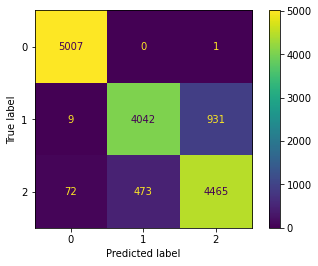

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(torch.cat(all_gts).numpy(), torch.cat(all_predictions).numpy(), labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot()
plt.show()

In [65]:
np.equal(torch.cat(all_gts).numpy(), torch.cat(all_predictions).numpy()).sum() / len(torch.cat(all_gts))

0.9009333333333334

In [66]:
consolidated_val_results = torch.cat((torch.cat(all_probabilities).unsqueeze(1), torch.cat(all_predictions).unsqueeze(1), torch.cat(all_gts).unsqueeze(1)), dim=1).numpy()

In [67]:
val_results = pd.DataFrame(consolidated_val_results, columns=['Probabilities', 'Predictions', 'Ground Truth'])

In [68]:
val_results.to_csv(os.path.join(root_path, "val_results.csv"), index=False)

In [69]:
train_dataset = classification_dataset(train_data, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=False, num_workers=0, drop_last=False, shuffle=False)

In [70]:
softmax = nn.Softmax(dim=1)
all_predictions = []
all_probabilities = []
all_gts = []
with torch.no_grad():
        model.eval()

        total_train_loss = 0
        total_train_batches = 0
        
        for batch, (data, labels) in enumerate(train_dataloader):
            if use_cuda:
                data = data.cuda()
                labels = labels.cuda()
        
            outs = model(data)
            preds = softmax(outs).detach().cpu()
            all_predictions.append(torch.argmax(preds, dim=1))
            all_probabilities.append(torch.max(preds, dim=1)[0])
            all_gts.append(labels.detach().cpu())

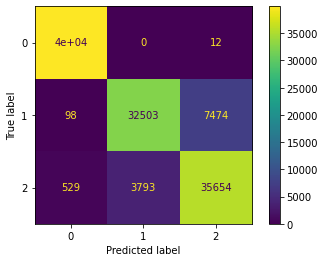

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(torch.cat(all_gts).numpy(), torch.cat(all_predictions).numpy(), labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot()
plt.show()

In [72]:
np.equal(torch.cat(all_gts).numpy(), torch.cat(all_predictions).numpy()).sum() / len(torch.cat(all_gts))

0.9007833333333334

In [73]:
consolidated_train_results = torch.cat((torch.cat(all_probabilities).unsqueeze(1), torch.cat(all_predictions).unsqueeze(1), torch.cat(all_gts).unsqueeze(1)), dim=1).numpy()

In [74]:
train_results = pd.DataFrame(consolidated_train_results, columns=['Probabilities', 'Predictions', 'Ground Truth'])

In [75]:
train_results.to_csv(os.path.join(root_path, "train_results.csv"), index=False)